In [112]:
# make the screen bigger!
from IPython.display import display, HTML
display(HTML(data=""" <style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 85%; }
    
    div#maintoolbar-container { width: 99%; } </style> """))

import os
import numpy as np
import pandas as pd
import gdal
import ogr
import geopandas as gpd
import glob
import shutil
import fiona

%matplotlib notebook

In [32]:
def createBuffer(inputfn, outputBufferfn, bufferDist):
    inputds = ogr.Open(inputfn)
    inputlyr = inputds.GetLayer()

    shpdriver = ogr.GetDriverByName('ESRI Shapefile')
    if os.path.exists(outputBufferfn):
        shpdriver.DeleteDataSource(outputBufferfn)
    outputBufferds = shpdriver.CreateDataSource(outputBufferfn)
    bufferlyr = outputBufferds.CreateLayer(outputBufferfn, geom_type=ogr.wkbPolygon)
    featureDefn = bufferlyr.GetLayerDefn()

    for feature in inputlyr:
        ingeom = feature.GetGeometryRef()
        geomBuffer = ingeom.Buffer(bufferDist)

        outFeature = ogr.Feature(featureDefn)
        outFeature.SetGeometry(geomBuffer)
        bufferlyr.CreateFeature(outFeature)
        outFeature = None

In [33]:
# set/create GENeral workspace
workspace = os.path.join('.', 'workspace_small')            ####### note changed this to workspace_small for the test files stuff
if not os.path.exists(workspace):
    os.makedirs(workspace)

# Paths to data
GIS_FOLDER = os.path.join('..', 'Raw_GIS_Data')

# path to the grid bound
Grid_shp = os.path.join(GIS_FOLDER, 'grid_bound.shp')

# path to the raw land use data set
LU_shp = os.path.join(GIS_FOLDER, 'Land_use', 'LU_test_file.shp')

if not os.path.exists(os.path.join('.', 'output//')):
    os.makedirs(os.path.join('.', 'output//'))
                        
if not os.path.exists(os.path.join('.', 'output//Figures//')):
    os.makedirs(os.path.join('.', 'output//Figures//'))
fig_path =  (os.path.join('.', 'output//Figures//'))

# define where the land is too steep to build
steep_land = os.path.join(GIS_FOLDER, 'Slopes', 'steep_land_25deg.shp')

In [42]:
#Make a copy of the raw shapefile in the workspace
FL = glob.glob(os.path.join(GIS_FOLDER, 'Land_use', 'LU_test_file_smal.*'))     # this is all because shapefiles have multiple files with different extensions
for i in FL: 
    shutil.copy(i, os.path.join(workspace, "Copyof_{}".format(i.split("\\")[-1])))
    
copy_LU_shp = os.path.join(workspace, "Copyof_LU_test_file_smal.shp")

In [83]:
# succsss
type_list =     ['Agroforest', 'Cultivated_Land', 'Developed_Woodlands', 'Open_Space', 'Impervious_Surfaces', 'Buildings']
Buf_dist_list = [5,             4,                 3,                     1,            0.2,                   0.5]


dataSrc = gpd.read_file(copy_LU_shp)  # Read in lad use data

# Step 1 buffer files 
Agroforest_select = dataSrc[dataSrc['LBLCLASS'] == 'Agroforest'].copy()
Agroforest_select['geometry'] = Agroforest_select.geometry.buffer(5)

Cultivated_Land_select = dataSrc[dataSrc['LBLCLASS'] == 'Cultivated_Land'].copy()
Cultivated_Land_select['geometry'] = Cultivated_Land_select.geometry.buffer(4)

Developed_Woodlands_select = dataSrc[dataSrc['LBLCLASS'] == 'Developed_Woodlands'].copy()
Developed_Woodlands_select['geometry'] = Developed_Woodlands_select.geometry.buffer(3)

Open_Space_select = dataSrc[dataSrc['LBLCLASS'] == 'Open_Space'].copy()
Open_Space_select['geometry'] = Open_Space_select.geometry.buffer(1)

Impervious_Surfaces_select = dataSrc[dataSrc['LBLCLASS'] == 'Impervious_Surfaces'].copy()
Impervious_Surfaces_select['geometry'] = Impervious_Surfaces_select.geometry.buffer(0.2)

Buildings_select = dataSrc[dataSrc['LBLCLASS'] == 'Buildings'].copy()
Buildings_select['geometry'] = Buildings_select.geometry.buffer(0.5)


# Step 2 Create erase unions 
LU_frame_expanded = dataSrc.copy()   # copy the dataset 

%time erase_step1 = gpd.overlay(LU_frame_expanded, Agroforest_select, how='difference')           # difference them both  (listed as inner then outer)
%time LU_frame_expanded = gpd.GeoDataFrame( pd.concat( [Agroforest_select, erase_step1], ignore_index=True) )    # Keep the inner one 

%time erase_step2 = gpd.overlay(LU_frame_expanded, Cultivated_Land_select, how='difference')           # difference them both  (listed as inner then outer)
%time LU_frame_expanded = gpd.GeoDataFrame( pd.concat( [Cultivated_Land_select, erase_step2], ignore_index=True) )    # Keep the inner one 

%time erase_step3 = gpd.overlay(LU_frame_expanded, Developed_Woodlands_select, how='difference')           # difference them both  (listed as inner then outer)
%time LU_frame_expanded = gpd.GeoDataFrame( pd.concat( [Developed_Woodlands_select, erase_step3], ignore_index=True) )    # Keep the inner one 

%time erase_step4 = gpd.overlay(LU_frame_expanded, Open_Space_select, how='difference')           # difference them both  (listed as inner then outer)
%time LU_frame_expanded = gpd.GeoDataFrame( pd.concat( [Open_Space_select, erase_step4], ignore_index=True) )    # Keep the inner one 

%time erase_step5 = gpd.overlay(LU_frame_expanded, Impervious_Surfaces_select, how='difference')           # difference them both  (listed as inner then outer)
%time LU_frame_expanded = gpd.GeoDataFrame( pd.concat( [Impervious_Surfaces_select, erase_step5], ignore_index=True) )    # Keep the inner one 

%time erase_step6 = gpd.overlay(LU_frame_expanded, Buildings_select, how='difference')           # difference them both  (listed as inner then outer)
%time LU_frame_expanded = gpd.GeoDataFrame( pd.concat( [Buildings_select, erase_step6], ignore_index=True) )    # Keep the inner one 

LU_frame_expanded.to_file(os.path.join(workspace, 'Finished_dataframetest1.shp'))


In [134]:
LU_frame_expanded['geometry'].area

0    35361.137985
1    24513.687473
2    25862.299873
3    51694.912465
4    52099.137643
5    16183.590482
6     3158.737418
7      438.285628
8      193.766027
dtype: float64

<IPython.core.display.Javascript object>


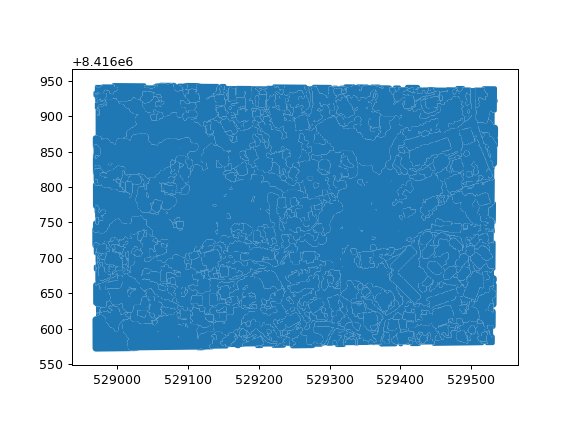

In [128]:
LU_frame_expanded.plot()

In [ ]:
SYNTAX
%time erase_step1 = gpd.overlay(Buildings_select, Impervious_Surfaces_select, how='difference')           # difference them both  (listed as inner then outer)
%time union_step1 = gpd.GeoDataFrame( pd.concat( [Buildings_select, erase_step1], ignore_index=True) )    # Keep the inner one 

%time erase_step2 = gpd.overlay(union_step1, Open_Space_select, how='difference')              
%time union_step2 = gpd.GeoDataFrame( pd.concat( [union_step1, erase_step2], ignore_index=True) )

%time erase_step3 = gpd.overlay(union_step2, Developed_Woodlands_select, how='difference')     
%time union_step3 = gpd.GeoDataFrame( pd.concat( [union_step2, erase_step3], ignore_index=True) )

%time erase_step4 = gpd.overlay(union_step3, Cultivated_Land_select, how='difference')     
%time union_step4 = gpd.GeoDataFrame( pd.concat( [union_step3, erase_step4], ignore_index=True) )

%time erase_step5 = gpd.overlay(union_step4, Agroforest_select, how='difference')     
%time union_step5 = gpd.GeoDataFrame( pd.concat( [union_step4, erase_step5], ignore_index=True) )


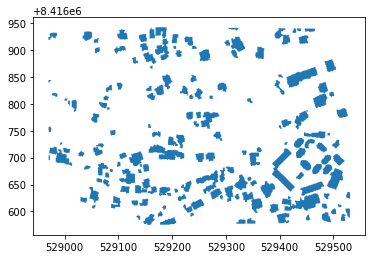

In [105]:
erase_step1.plot()

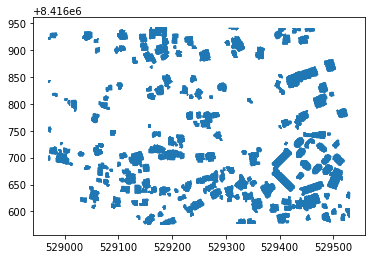

In [102]:
union_step3.plot()

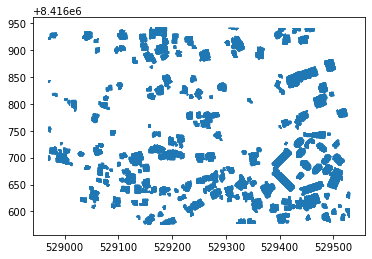

In [103]:
union_step4.plot()

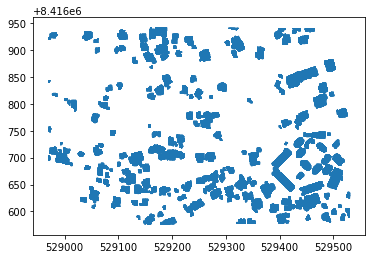

In [104]:
union_step5.plot()

In [ ]:
%time erase_step2 = gpd.overlay(union_step1, Open_Space_select, how='difference')              #  difference them both  (listed as inner then outer)
%time union_step2 = gpd.overlay(union_step1, erase_step2, how='union')                         # Keep the inner one                             # WHY TAKE SO LONG?

%time erase_step3 = gpd.overlay(union_step2, Developed_Woodlands_select, how='difference')     # difference them both  (listed as inner then outer)
%time union_step3 = gpd.overlay(union_step2, erase_step3, how='union')                         # Keep the inner one


In [48]:
######## Using OGR
type_list =     ['Agroforest', 'Cultivated_Land', 'Developed_Woodlands', 'Open_Space', 'Impervious_Surfaces', 'Buildings']
Buf_dist_list = [5,             4,                 3,                     1,            0.2,                   0.5]


# Step 1 buffer files 
# use geopandas to select each landuse independently
dataSrc = gpd.read_file(copy_LU_shp)

for idx, lutype in enumerate(type_list):
    dataSrc_select = dataSrc[dataSrc['LBLCLASS'] == lutype]
    #dataSrc_select.to_file(os.path.join(workspace, 'tempselect.shp'))

    # use OGR to create the buffer file 
    print("buffering {}".format(lutype))
    %time  createBuffer(os.path.join(workspace, 'tempselect.shp'), os.path.join(workspace, 'Buffer_{}.shp'.format(lutype)), Buf_dist_list[idx])  


buffering Agroforest
Wall time: 437 ms
buffering Cultivated_Land
Wall time: 419 ms
buffering Developed_Woodlands
Wall time: 476 ms
buffering Open_Space
Wall time: 547 ms
buffering Impervious_Surfaces
Wall time: 650 ms
buffering Buildings
Wall time: 616 ms


In [ ]:
%time dataSrc_select['geometry'] = dataSrc_select.geometry.buffer(5)   # use geopandas instead of (OGR = Stupid_)

In [47]:
######## Using GPD
type_list =     ['Agroforest', 'Cultivated_Land', 'Developed_Woodlands', 'Open_Space', 'Impervious_Surfaces', 'Buildings']
Buf_dist_list = [5,             4,                 3,                     1,            0.2,                   0.5]


# Step 1 buffer files 
# use geopandas to select each landuse independently
dataSrc = gpd.read_file(copy_LU_shp)

for idx, lutype in enumerate(type_list):
    dataSrc_select = dataSrc[dataSrc['LBLCLASS'] == lutype]
    #dataSrc_select.to_file(os.path.join(workspace, 'tempselect.shp'))

    # use OGR to create the buffer file 
    print("buffering {}".format(lutype))
    %time dataSrc_select['geometry'] = dataSrc_select.geometry.buffer(Buf_dist_list[idx])

buffering Agroforest


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Wall time: 349 ms
buffering Cultivated_Land
Wall time: 552 ms
buffering Developed_Woodlands
Wall time: 929 ms
buffering Open_Space
Wall time: 304 ms
buffering Impervious_Surfaces
Wall time: 378 ms
buffering Buildings
Wall time: 320 ms


In [72]:
# now make a super bufferfile from the buffers by join and eracing them 


    
    


Impervious_Surfaces
Open_Space
Developed_Woodlands
Cultivated_Land
Agroforest


In [59]:
type_list =     ['Agroforest', 'Cultivated_Land', 'Developed_Woodlands', 'Open_Space', 'Impervious_Surfaces', 'Buildings']


In [73]:
reversetype_list

['Buildings',
 'Impervious_Surfaces',
 'Open_Space',
 'Developed_Woodlands',
 'Cultivated_Land',
 'Agroforest']

In [19]:
type_list =     ['Agroforest', 'Cultivated_Land', 'Developed_Woodlands', 'Open_Space', 'Impervious_Surfaces', 'Buildings']
Buf_dist_list = [5,             4,                 3,                     1,            0.2,                   0.5]

# use geopandas to select each landuse independently
dataSrc = gpd.read_file(copy_LU_shp)

for idx, lutype in enumerate(type_list):
    dataSrc_select = dataSrc[dataSrc['LBLCLASS'] == lutype]
    dataSrc_select.to_file(os.path.join(workspace, 'tempselect.shp'))

    # use OGR to create the buffer file 
    print("buffering {}".format(lutype))
    %time  createBuffer(os.path.join(workspace, 'tempselect.shp'), os.path.join(workspace, 'Buffer_{}.shp'.format(lutype)), Buf_dist_list[idx])
    



buffering Agroforest
Wall time: 14.2 s
buffering Cultivated_Land
Wall time: 21.7 s
buffering Developed_Woodlands
Wall time: 46.5 s
buffering Open_Space
Wall time: 3min 14s
buffering Impervious_Surfaces
Wall time: 2min 28s
buffering Buildings
Wall time: 2min


In [20]:
for idx, lutype in enumerate(type_list):
    print(idx)
    print(lutype)

0
Agroforest
1
Cultivated_Land
2
Developed_Woodlands
3
Open_Space
4
Impervious_Surfaces
5
Buildings


In [ ]:
Erasein1 = gpd.read_file(os.path.join(workspace, 'Buffer_{}.shp'.format(lutype[5-idx])))
Erasein2 = gpd.read_file(os.path.join(workspace, 'Buffer_{}.shp'.format(lutype[4-idx])))

%time erasestep1time = gpd.overlay(Erasein1, Erasein2, how='difference')
erasestep1time.to_file(os.path.join(workspace, 'Buffer_{}.shp'.format('testbong1'))
                       
print("unioning back in on copymaster {}".format('1'))
%time erasestep2time = gpd.overlay(Erasein1, Erasein2, how='union')   
erasestep1time.to_file(os.path.join(workspace, 'Buffer_{}.shp'.format('testbong2'))

In [ ]:
for idx, lutype in enumerate(type_list):
    print("erasing on copymaster {}".format(lutype))
    Erasein1 = gpd.read_file(os.path.join(workspace, 'Buffer_{}.shp'.format(lutype)))
    Erasein2 = gpd.read_file(os.path.join(workspace, 'Buffer_{}.shp'.format(type_list[idx+1])))
    
    %time newlandusefile = gpd.overlay(Erasein1, Erasein2, how='difference')
    newlandusefile.to_file(copy_LU_shp)
       
    print("unioning back in on copymaster {}".format(lutype))
    %time newlandusefile2 = gpd.overlay(Erasein1, Erasein2, how='union')   
    newlandusefile2.to_file(copy_LU_shp)

In [ ]:
Process: 
    - project the land use file 
    - define the buffer distances for each land use type
    - for each land use type: 
        - create stand alone shapefile of desired type
        - buffer it by desired amount save each buffer file
        - Perdorm a difference then a union on each of the buffers sequentially to make a master expanded land uses shape (itself having 5 land usees)
        - erase then union this master shape with the big (but simplified) 
        
        
        
        
        
        
        
        
        
        
        
        
        
        
############## eratly attempts to do an erase with ogr

driver = ogr.GetDriverByName('ESRI Shapefile')
outDriver = ogr.GetDriverByName("ESRI Shapefile")  

inlayer = driver.Open(os.path.join(workspace, 'Buffer_Open_Space.shp'), 0)
eraselayer = driver.Open(os.path.join(workspace, 'Buffer_Buildings.shp'), 0)
outDataSource = outDriver.CreateDataSource(os.path.join(workspace, 'trashfaceman.shp'))


feat1.Erase(eraselayer, outDataSource)

<osgeo.ogr.DataSource; proxy of <Swig Object of type 'OGRDataSourceShadow *' at 0x000001881365D810> >

In [ ]:
good links 
https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
    https://gis.stackexchange.com/questions/163040/erasing-features-using-python-gdal-ogr
    